# Analyzing sampling result

In this tutorial, we will show how to analyze the sampling result from `flowMC` using `arviz`. In particular, we will look at $\hat{R}$ and effective sample size (ESS) to check convergence and efficiency of the sampling result.

In [30]:
from flowMC.nfmodel.rqSpline import RQSpline
from flowMC.sampler.MALA import make_mala_sampler

import jax
import jax.numpy as jnp  # JAX NumPy
from jax.scipy.special import logsumexp
import numpy as np

from flowMC.sampler.Sampler import Sampler
from flowMC.utils.PRNG_keys import initialize_rng_keys

from flowMC.nfmodel.utils import *


def dual_moon_pe(x):
    """
    Term 2 and 3 separate the distribution and smear it along the first and second dimension
    """
    term1 = 0.5 * ((jnp.linalg.norm(x) - 2) / 0.1) ** 2
    term2 = -0.5 * ((x[:1] + jnp.array([-3.0, 3.0])) / 0.8) ** 2
    term3 = -0.5 * ((x[1:2] + jnp.array([-3.0, 3.0])) / 0.6) ** 2
    return -(term1 - logsumexp(term2) - logsumexp(term3))


### Demo config

n_dim = 5
n_chains = 20
n_loop_training = 5
n_loop_production = 5
n_local_steps = 100
n_global_steps = 100
learning_rate = 0.01
momentum = 0.9
num_epochs = 30
batch_size = 10000

print("Preparing RNG keys")
rng_key_set = initialize_rng_keys(n_chains, seed=42)

print("Initializing MCMC model and normalizing flow model.")

initial_position = jax.random.normal(rng_key_set[0], shape=(n_chains, n_dim)) * 1
model = RQSpline(n_dim, 10, [128, 128], 8)
local_sampler_caller = lambda x: make_mala_sampler(x, jit=True)

print("Initializing sampler class")

nf_sampler = Sampler(
    n_dim,
    rng_key_set,
    local_sampler_caller,
    {'dt':1e-1},
    dual_moon_pe,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=True,
)

nf_sampler_local = Sampler(
    n_dim,
    rng_key_set,
    local_sampler_caller,
    {'dt':1e-1},
    dual_moon_pe,
    model,
    n_loop_training=n_loop_training,
    n_loop_production=n_loop_production*2,
    n_local_steps=n_local_steps,
    n_global_steps=n_global_steps,
    n_chains=n_chains,
    n_epochs=num_epochs,
    learning_rate=learning_rate,
    momentum=momentum,
    batch_size=batch_size,
    use_global=False,
)

print("Sampling")

nf_sampler.sample(initial_position)
nf_sampler_local.sample(initial_position)

summary = nf_sampler.get_sampler_state()
chains, log_prob, local_accs, global_accs = summary.values() 
summary_local = nf_sampler_local.get_sampler_state()
chains_local, log_prob_local, local_accs_local, global_accs_local = summary_local.values()

Preparing RNG keys
Initializing MCMC model and normalizing flow model.
Initializing sampler class
Sampling
No autotune found, use input sampler_params
Training normalizing flow


Sampling Locally: 100%|██████████| 99/99 [00:00<00:00, 449.03it/s]


No autotune found, use input sampler_params


Sampling Locally: 100%|██████████| 99/99 [00:00<00:00, 226.41it/s]


In [11]:
import arviz as az

In [26]:
data = az.convert_to_inference_data(np.array(chains))
data_local = az.convert_to_inference_data(np.array(chains_local))

array([[<AxesSubplot:ylabel='x\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='x\n2'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='x\n3'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='x\n0', ylabel='x\n4'>,
        <AxesSubplot:xlabel='x\n1'>, <AxesSubplot:xlabel='x\n2'>,
        <AxesSubplot:xlabel='x\n3'>]], dtype=object)

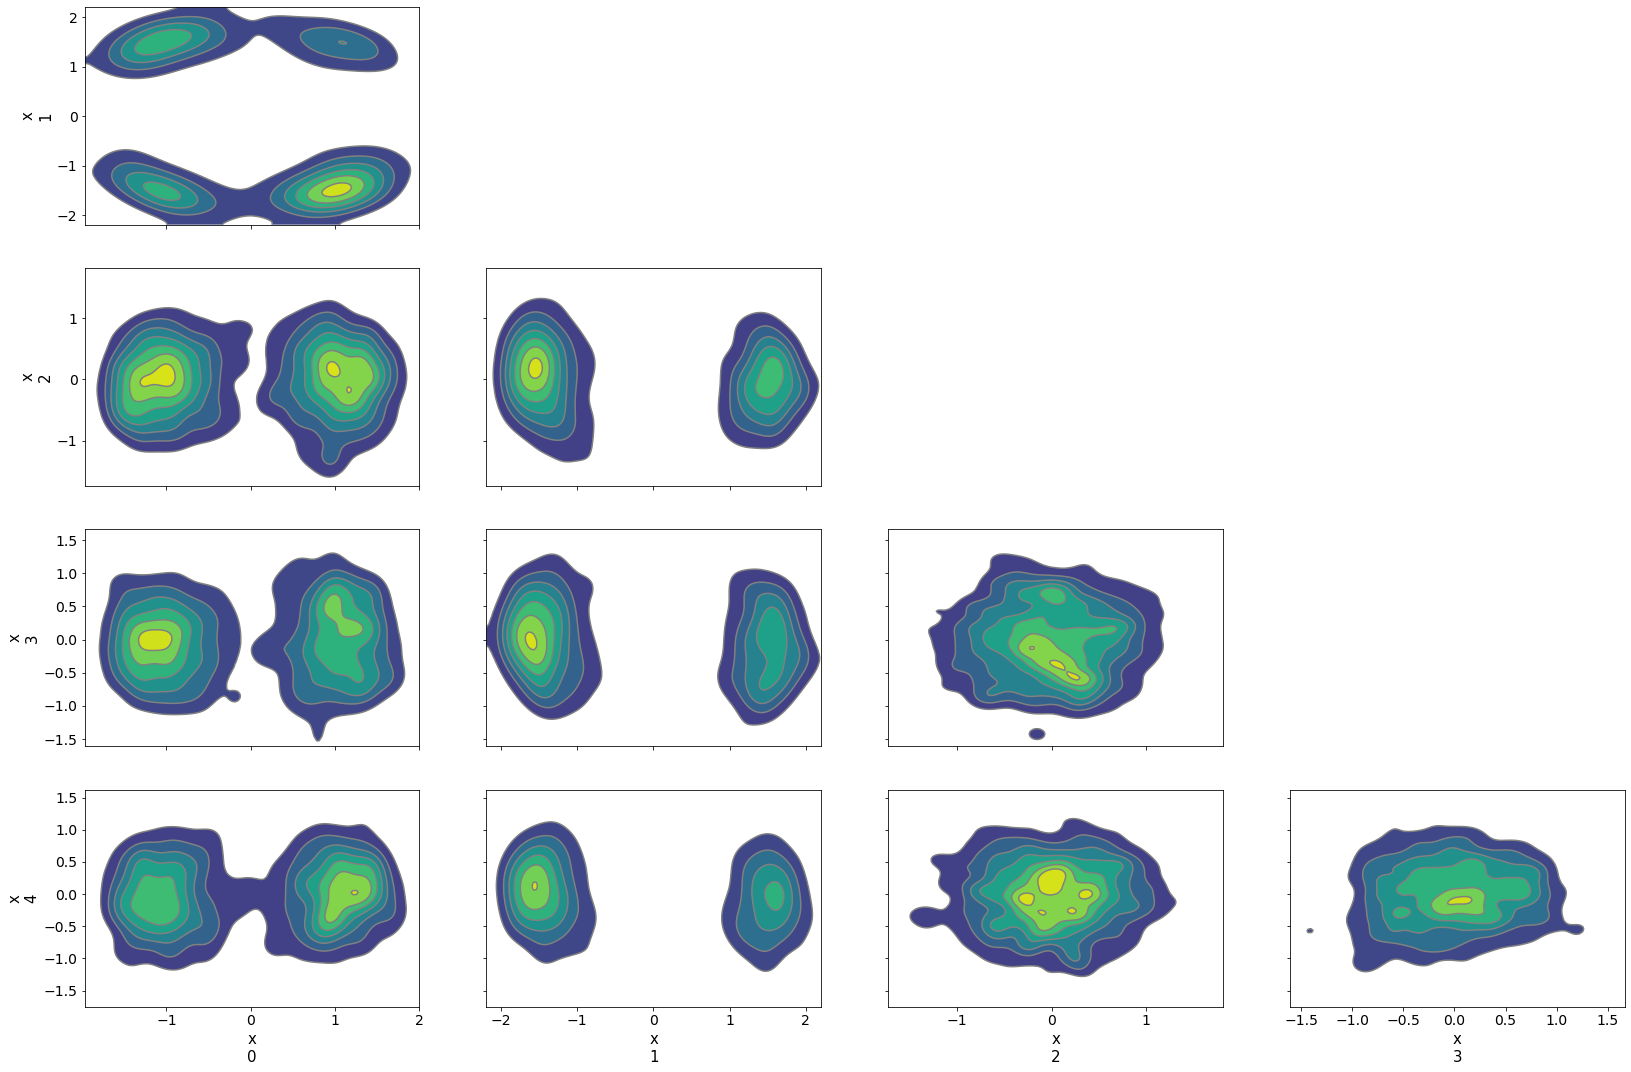

In [28]:
az.plot_pair(data, kind='kde')


array([[<AxesSubplot:ylabel='x\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='x\n2'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='x\n3'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='x\n0', ylabel='x\n4'>,
        <AxesSubplot:xlabel='x\n1'>, <AxesSubplot:xlabel='x\n2'>,
        <AxesSubplot:xlabel='x\n3'>]], dtype=object)

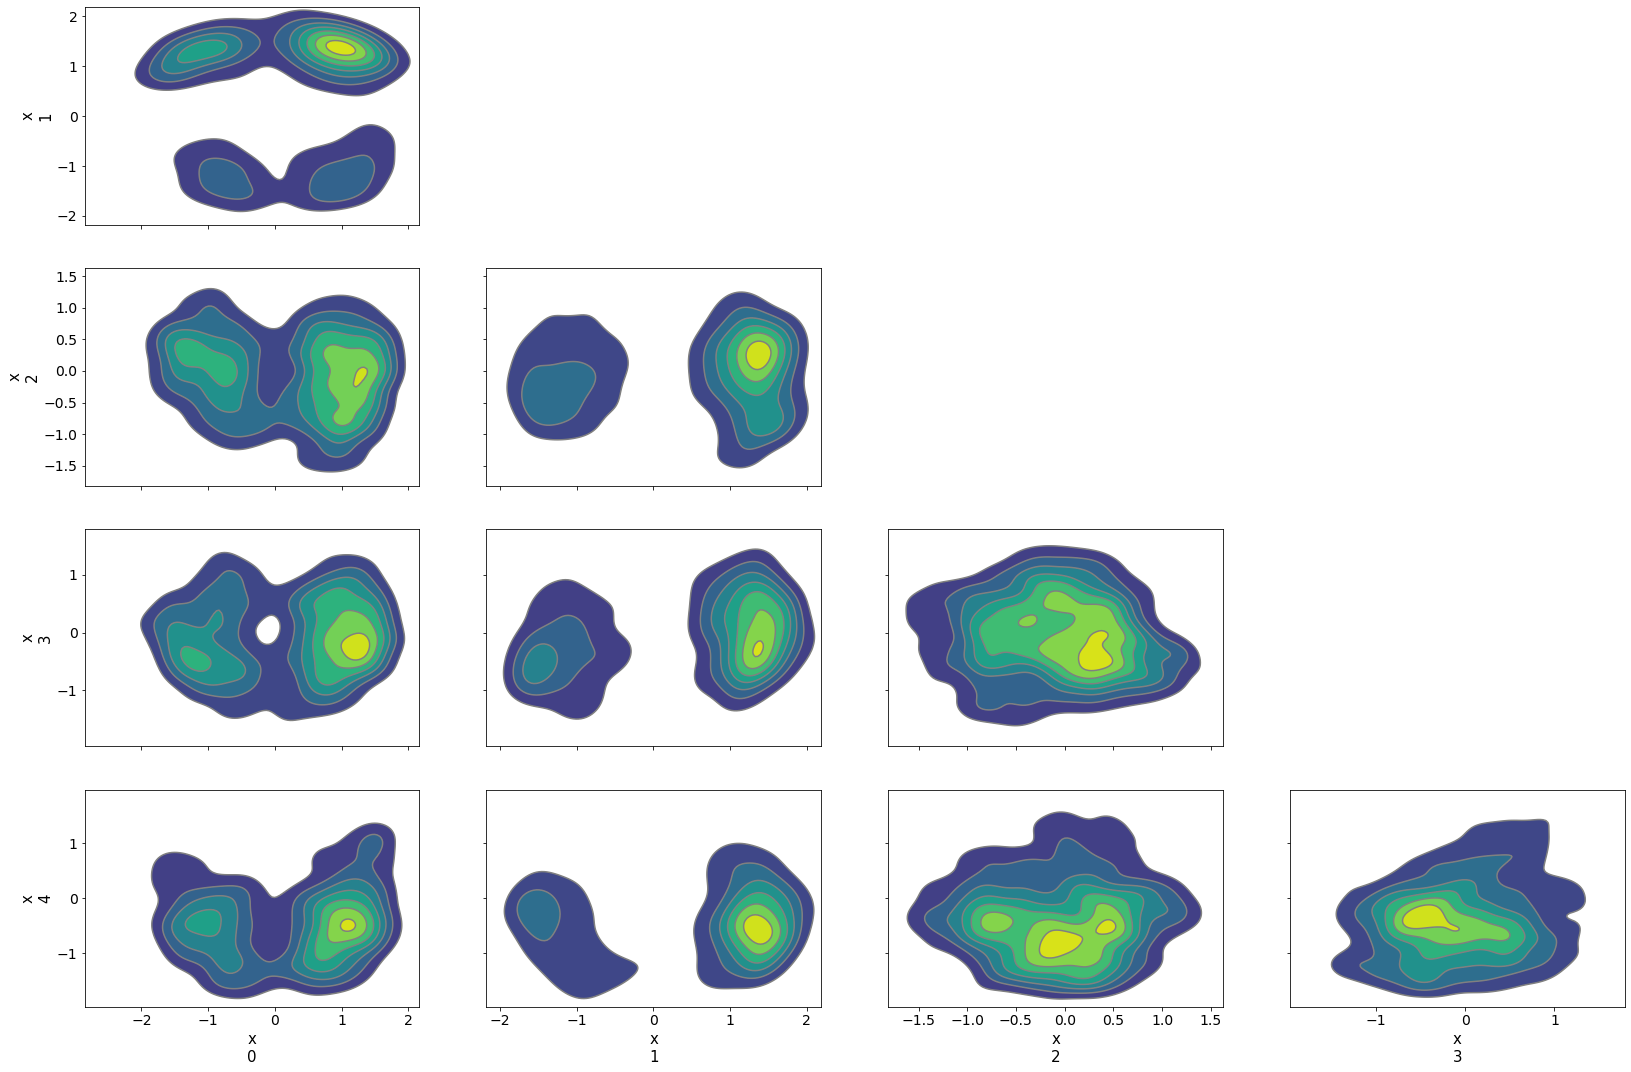

In [29]:
az.plot_pair(data_local, kind='kde')

In [32]:
az.rhat(data)

<xarray.Dataset>
Dimensions:  (x_dim_0: 5)
Coordinates:
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4
Data variables:
    x        (x_dim_0) float64 1.124 1.152 1.089 1.107 1.096

In [33]:
az.rhat(data_local)

<xarray.Dataset>
Dimensions:  (x_dim_0: 5)
Coordinates:
  * x_dim_0  (x_dim_0) int64 0 1 2 3 4
Data variables:
    x        (x_dim_0) float64 2.053 1.756 1.576 1.582 1.631

In [35]:
az.ess(data), az.ess(data_local)

(<xarray.Dataset>
 Dimensions:  (x_dim_0: 5)
 Coordinates:
   * x_dim_0  (x_dim_0) int64 0 1 2 3 4
 Data variables:
     x        (x_dim_0) float64 165.8 118.9 159.2 129.7 150.8,
 <xarray.Dataset>
 Dimensions:  (x_dim_0: 5)
 Coordinates:
   * x_dim_0  (x_dim_0) int64 0 1 2 3 4
 Data variables:
     x        (x_dim_0) float64 27.03 30.91 35.25 35.65 34.02)